In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

import experiment_utils
import util

import imageio


import jax
import jax.numpy as jnp
from jax.random import split
from clip_jax import MyFlaxCLIP
import imageio
from umap import UMAP

# clip_model = MyFlaxCLIP()

In [3]:
from create_sim import create_sim, rollout_and_embed_simulation, rollout_simulation, FlattenSimulationParameters
from models.models_gol import GameOfLife

In [4]:
T = 500
img_size = 256
cover_video = []

In [5]:
pop = util.load_pkl("/home/akarsh_sakana_ai/nca-alife-data/illumination/0_lenia_1.0_large/", "pop")
sim = FlattenSimulationParameters(create_sim('lenia_1.0'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=256, img_size=img_size, n_rollout_imgs='video'))

# params = pop['params'][np.array([5729, 5069, 5331, 4443, 4687, 5685, 5566, 5562, 1300, 4893, 4894, 1170, 1163, 1933, 1153, 29])]
params = pop['params'][np.array([5069, 5331, 4687, 5685, 5566, 5562, 4893, 4894, 1170, 1933, 1153, 29])]

rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb']
vid = jax.image.resize(vid, (len(vid), T, img_size, img_size, 3), method='bilinear')
print(vid.shape)
vids_lenia = np.array(vid)
del vid, rollout_data

2024-12-23 00:50:34.592396: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 3117 parameters detected for optimization.
(12, 500, 256, 256, 3)


In [6]:
pop = util.load_pkl("/home/akarsh_sakana_ai/nca-alife-data/illumination/0_boids_large/", "pop")
sim = FlattenSimulationParameters(create_sim('boids'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=img_size, n_rollout_imgs=T))

# params = pop['params'][np.array([1753, 2141, 2034, 1383, 1977, 1855, 1319, 1829, 2089, 2597, 3086, 4113, 4619, 4491, 6409, 6410])]
params = pop['params'][np.array([1753, 2141, 2034, 1383, 1977, 1319, 2089, 3086, 4113, 4491, 6409, 6410])]
rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb']
# vid = jax.image.resize(vid, (len(vid), T, img_size, img_size, 3), method='bilinear')
print(vid.shape)
vids_boids = np.array(vid)
del vid, rollout_data

ParameterReshaper: 193 parameters detected for optimization.
(12, 500, 256, 256, 3)


In [7]:
pop = util.load_pkl("/home/akarsh_sakana_ai/nca-alife-data/illumination/0_plife_ba/", "pop")
sim = FlattenSimulationParameters(create_sim('plife_ba'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=3000, img_size=img_size, n_rollout_imgs=T))

params = pop['params'][:6]
rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb']
# vid = jax.image.resize(vid, (len(vid), T, img_size, img_size, 3), method='bilinear')
print(vid.shape)
vids_plife = np.array(vid)
del vid, rollout_data

ParameterReshaper: 42 parameters detected for optimization.
(6, 500, 256, 256, 3)


In [8]:
from models.models_plife_plus import ParticleLifePlus
sim = ParticleLifePlus(n_particles=1000, dt=0.02, render_radius=0.04, sharpness=30., background_color='black')
# sim = FlattenSimulationParameters(create_sim('plife_ba'))
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1500, img_size=img_size, n_rollout_imgs=T))

rng = jax.random.PRNGKey(20)
seeds = [20, 6, 7, 23, 100, 211]
seeds = np.stack([jax.random.PRNGKey(seed) for seed in seeds])
params = jax.vmap(sim.default_params)(seeds)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params)

vid = rollout_data['rgb']
print(vid.shape)
vids_plife_plus = np.array(vid)
del vid, rollout_data

(6, 500, 256, 256, 3)


In [9]:
sim = GameOfLife(grid_size=64)
rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=img_size, n_rollout_imgs=T))

rng = jax.random.PRNGKey(119)

# params = np.array([7291, 133519, 33823, 55615, 2579, 55871, 7787, 15923, 36703, 47999, ] + [2579, 55871, 7787, 15923, 36703, 47999])
params = np.array([7291, 7787, 55871, 15923, 2579, 5691, 47999, 55615, 56127, 8059, 36703, 133519])
rng = np.array([jax.random.PRNGKey(119)]*12)

rollout_data = jax.vmap(rollout_fn, in_axes=(0, 0))(rng, params)
vid = rollout_data['rgb']
# vid = jax.image.resize(vid, (len(vid), 1000, img_size, img_size, 3), method='nearest')
print(vid.shape)
vids_gol = np.array(vid)
del vid, rollout_data

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


(12, 500, 256, 256, 3)


In [10]:
vids_lenia.shape, vids_boids.shape, vids_plife.shape, vids_plife_plus.shape, vids_gol.shape

((12, 500, 256, 256, 3),
 (12, 500, 256, 256, 3),
 (6, 500, 256, 256, 3),
 (6, 500, 256, 256, 3),
 (12, 500, 256, 256, 3))

In [11]:
cover_vid = np.concatenate([vids_lenia, vids_boids, vids_plife, vids_plife_plus, vids_gol], axis=0)
print(cover_vid.shape)
cover_vid = np.pad(cover_vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(cover_vid.shape)
cover_vid = rearrange(cover_vid, "(K R C) T H W D -> T (R H) (K C W) D", R=4, K=4)
cover_vid = np.pad(cover_vid, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(cover_vid.shape)

(48, 500, 256, 256, 3)
(48, 500, 258, 258, 3)
(500, 1034, 3098, 3)


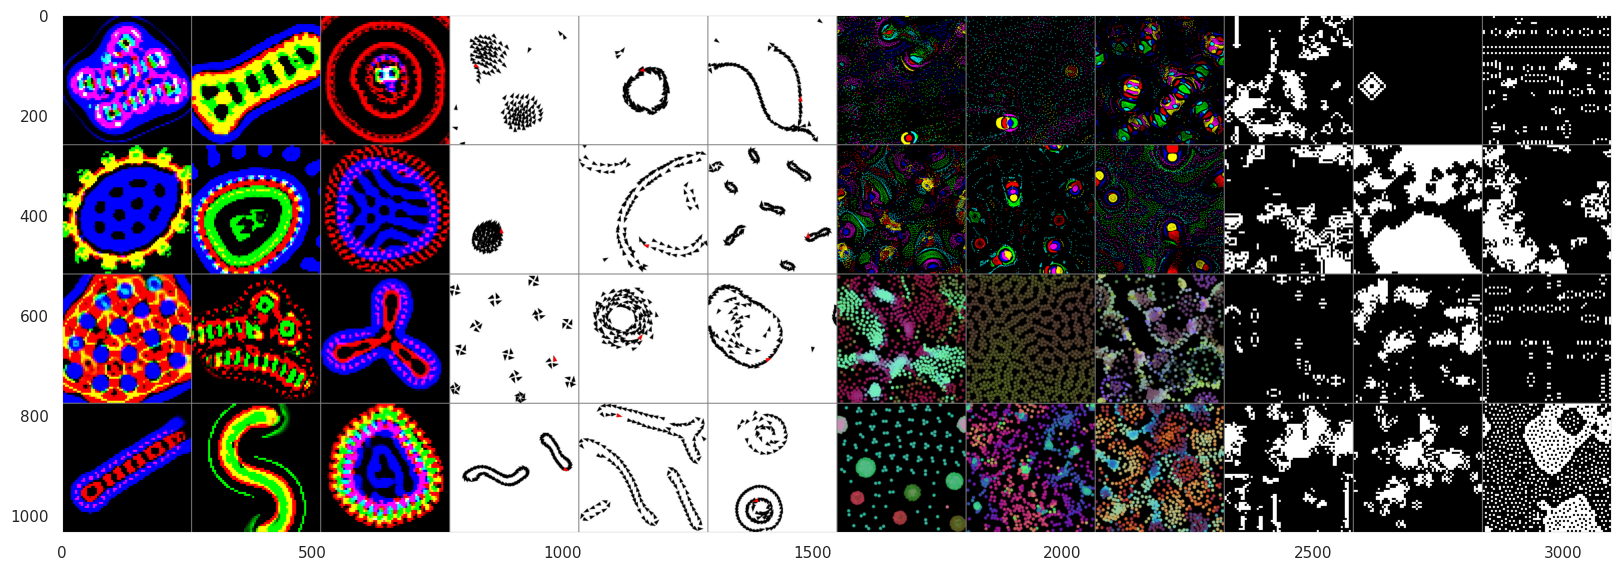

In [111]:
plt.figure(figsize=(20, 10))
plt.imshow(cover_vid[-1])
plt.grid(False)

In [115]:
plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/cover_video.png", cover_vid[-1])

In [112]:
# vid = jax.image.resize(cover_vid, (len(cover_vid), 1034//2, 3098//2, 3), method='bilinear')
vid = cover_vid[:, ::2, ::2]
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_final/cover_video_small.mp4", vid, fps=30, codec='libx264')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1549, 517) to (1552, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
[swscaler @ 0x6dc7f00] Warning: data is not aligned! This can lead to a speed loss


In [113]:
vid = cover_vid
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_final/cover_video.mp4", vid, fps=30, codec='libx264')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3098, 1034) to (3104, 1040) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6117f00] Warning: data is not aligned! This can lead to a speed loss


In [63]:
vid.shape

(500, 1034, 3098, 3)

In [80]:
vid.size*4/1e9

19.219992

In [32]:
cover_vid = np.concatenate([vids_lenia, vids_boids, vids_plife, vids_plife_plus, vids_gol], axis=0)
print(cover_vid.shape)
cover_vid = np.pad(cover_vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(cover_vid.shape)
cover_vid = rearrange(cover_vid, "(K1 K2 R C) T H W D -> T (K1 C H) (K2 R W) D", R=4, K1=2, K2=2)
cover_vid = np.pad(cover_vid, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(cover_vid.shape)

(48, 500, 256, 256, 3)
(48, 500, 258, 258, 3)
(500, 1550, 2066, 3)


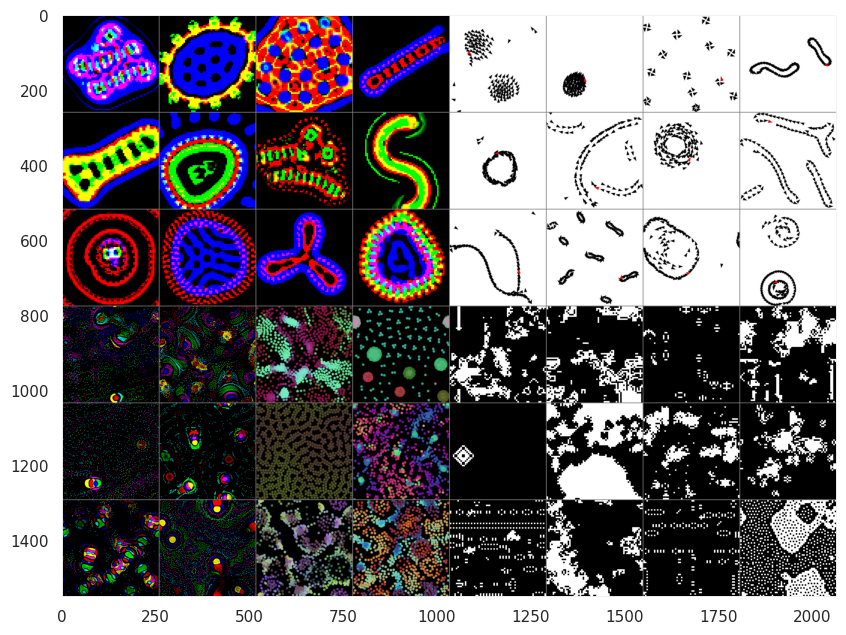

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(cover_vid[-1])
plt.grid(False)

In [35]:
plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/cover_video_square.png", cover_vid[-1])

In [37]:
vid = cover_vid[:, ::2, ::2]
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_final/cover_video_square_small.mp4", vid, fps=30, codec='libx264')

vid = cover_vid
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_final/cover_video_square.mp4", vid, fps=30, codec='libx264')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1033, 775) to (1040, 784) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x58efe80] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2066, 1550) to (2080, 1552) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5684f00] Warning: data is not aligned! This can lead to a speed loss


(64, 1000, 130, 130, 3)
(1000, 520, 2080, 3)


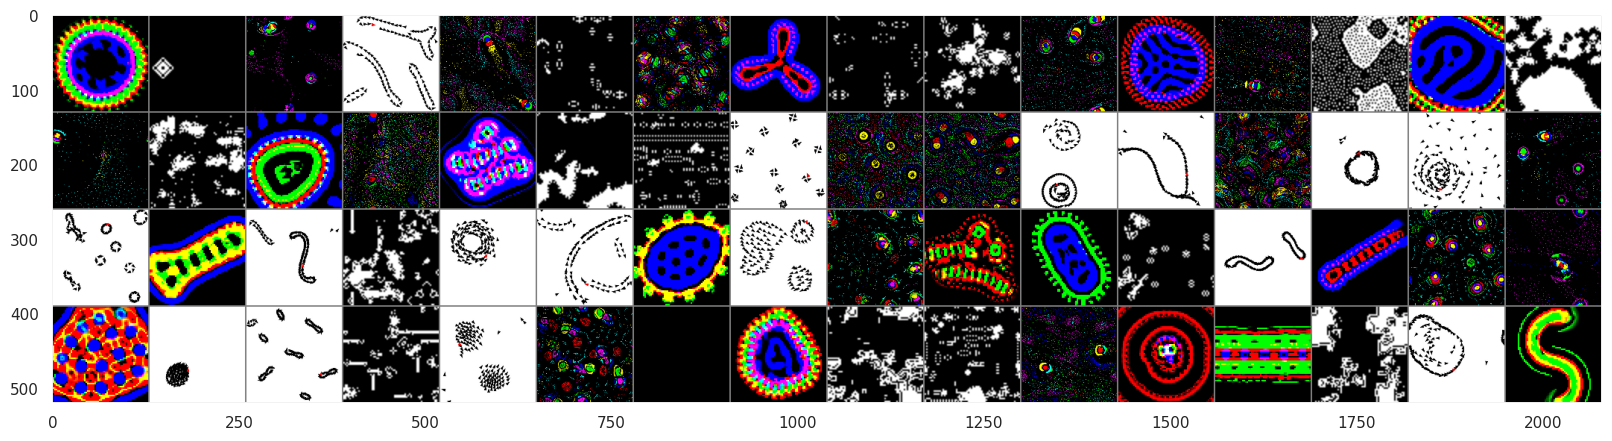

In [24]:
rng = jax.random.PRNGKey(2)
vid = np.concatenate(cover_video)
vid = vid[jax.random.permutation(rng, len(vid))]
# vid = rearrange(vid, "(A B C) T H W D -> (B A C) T H W D", A=4, B=4, C=4)
vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
print(vid.shape)
vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=4)
print(vid.shape)
plt.figure(figsize=(20, 10))
plt.imshow(vid[-1])
plt.grid(False)

In [25]:
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_vids/cover_video_shuffled.mp4", vid, fps=30, codec='libx264')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2080, 520) to (2080, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [81]:
sim = GameOfLife(grid_size=64*3)
# rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=64, n_rollout_imgs='video'))
params = jnp.array([6152, 133519, 7291, 33823, 55871, 7787, 15923, 36703, 47999])
# params = jnp.array([15923, 133519, 7291, 33823, 6152, 55871, 7787, 36703, 47999])

rng = jax.random.PRNGKey(0)
state = sim.init_state(rng, params[0])

@jax.jit
def step_state(rng, state, params):
    state = sim.step_state(rng, state, params)
    state = sim.step_state(rng, state, params)
    return state


rule_map = repeat(jnp.arange(9).reshape(3, 3), "X Y -> (X x) (Y y)", x=64, y=64)
row_indices, col_indices = np.meshgrid(np.arange(192), np.arange(192), indexing='ij')

states = []
for t in tqdm(range(2000)):
    state = jax.vmap(step_state, in_axes=(None, None, 0))(rng, state, params)
    state = state[rule_map, row_indices, col_indices]
    states.append(state)

states = np.array(states)



  0%|          | 0/2000 [00:00<?, ?it/s]

In [82]:
vid = np.array((repeat(states, "... -> ... 3")*255).astype(np.uint8))
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_vids/gol_mush.mp4", vid, fps=20, codec='libx264')

/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [95]:
sim = GameOfLife(grid_size=64*3)
# rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, rollout_steps=1000, img_size=64, n_rollout_imgs='video'))
params = jnp.array([6152, 133519, 7291, 33823, 55871, 7787, 15923, 36703, 47999])
# params = jnp.array([15923, 133519, 7291, 33823, 6152, 55871, 7787, 36703, 47999])

rng = jax.random.PRNGKey(0)
state = sim.init_state(rng, params[0])

@jax.jit
def step_state(rng, state, params):
    state = sim.step_state(rng, state, params)
    state = sim.step_state(rng, state, params)
    return state

rule_map = repeat(jnp.arange(9).reshape(3, 3), "X Y -> (X x) (Y y)", x=64, y=64)
row_indices, col_indices = np.meshgrid(np.arange(192), np.arange(192), indexing='ij')

states = []
for t in tqdm(range(200)):
    state = jax.vmap(step_state, in_axes=(None, None, 0))(rng, state, params)
    state = state[rule_map, row_indices, col_indices]
    states.append(state)

states = np.array(states)



  0%|          | 0/200 [00:00<?, ?it/s]

In [94]:
state = jax.vmap(step_state, in_axes=(None, None, 0))(rng, state, params)